# 01 — EDA (target + features)

Scoring requirements we cover here:
- target distribution + class balance
- target analysis in time context
- feature typization + distributions
- missing values + anomalies
- dependencies between features
- correlations / importance proxy
- hypothesis-driven mini-research (with plots)

In [2]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve()
if (PROJECT_ROOT / "src").exists() is False and (PROJECT_ROOT.parent / "src").exists():
    PROJECT_ROOT = PROJECT_ROOT.parent

sys.path.insert(0, str(PROJECT_ROOT))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("src exists:", (PROJECT_ROOT / "src").exists())

PROJECT_ROOT: /Users/sergey/code/renthop-lightautoml-vs-custom
src exists: True


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.config import Paths, TARGET_COL
from src.data.io import load_renthop_json
from src.features.build import build_base_dataframe

paths = Paths()
train, test = load_renthop_json(paths.data_raw/"train.json", paths.data_raw/"test.json")
df = build_base_dataframe(train)
df.head()

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,created_year,created_month,created_day,created_hour,created_dow,price_per_bed,price_per_bath,beds_plus_baths,street_address_clean,display_address_clean
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,...,2016,6,16,5,3,1200.000000,1200.0,2.0,145 borinquen place,145 borinquen place
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,...,2016,6,1,5,2,1266.666667,1900.0,3.0,230 east 44th,east 44th
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,...,2016,6,14,15,1,1165.000000,1747.5,3.0,405 east 56th street,east 56th street
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,2016,6,24,7,4,750.000000,1200.0,4.5,792 metropolitan avenue,metropolitan avenue
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,...,2016,6,28,3,1,2795.000000,1397.5,1.0,340 east 34th street,east 34th street


## 1) Target analysis

In [4]:
vc = df[TARGET_COL].value_counts()
display(vc)
display((vc / vc.sum()).rename("share"))

interest_level
low       34284
medium    11229
high       3839
Name: count, dtype: int64

interest_level
low       0.694683
medium    0.227529
high      0.077788
Name: share, dtype: float64

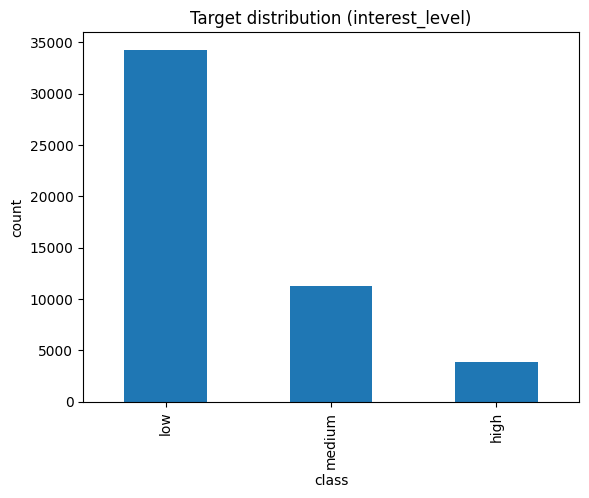

In [5]:
# Bar plot of class balance
ax = df[TARGET_COL].value_counts().plot(kind="bar")
ax.set_title("Target distribution (interest_level)")
ax.set_xlabel("class")
ax.set_ylabel("count")
plt.show()

### Target in time context (created timestamp)

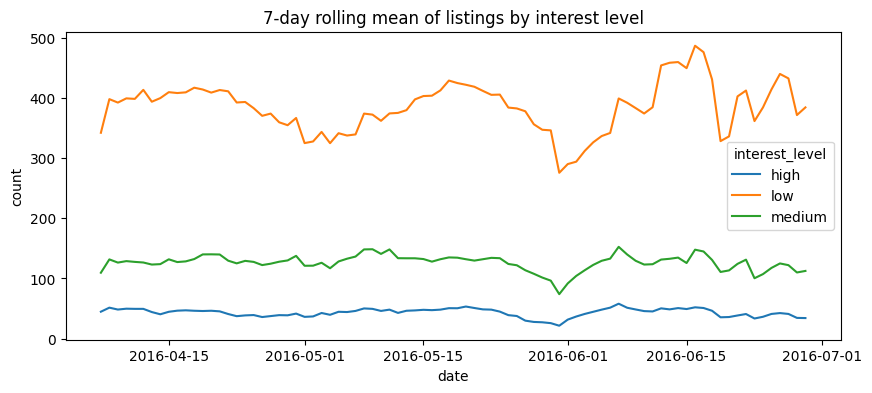

In [6]:
# Interest levels over time (daily counts)
tmp = df.copy()
tmp["date"] = tmp["created_dt"].dt.date
daily = tmp.groupby(["date", TARGET_COL]).size().reset_index(name="cnt")
pivot = daily.pivot(index="date", columns=TARGET_COL, values="cnt").fillna(0)

ax = pivot.rolling(7).mean().plot(figsize=(10,4))
ax.set_title("7-day rolling mean of listings by interest level")
ax.set_xlabel("date")
ax.set_ylabel("count")
plt.show()

## 2) Feature typization + distributions

In [7]:
numeric_cols = ["price", "bedrooms", "bathrooms", "latitude", "longitude", "n_photos", "n_features", "price_per_bed", "price_per_bath"]
cat_cols = ["manager_id", "building_id", "street_address_clean", "display_address_clean"]

df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
price,49352.0,3830.174036,22066.865885,43.000,2500.000000,3150.000000,4100.0000,4.490000e+06
bedrooms,49352.0,1.541640,1.115018,0.000,1.000000,1.000000,2.0000,8.000000e+00
bathrooms,49352.0,1.212180,0.501420,0.000,1.000000,1.000000,1.0000,1.000000e+01
latitude,49352.0,40.741545,0.638535,0.000,40.728300,40.751800,40.7743,4.488350e+01
longitude,49352.0,-73.955716,1.177912,-118.271,-73.991700,-73.977900,-73.9548,0.000000e+00
n_photos,49352.0,5.606946,3.632283,0.000,4.000000,5.000000,7.0000,6.800000e+01
n_features,49352.0,5.428473,3.923411,0.000,2.000000,5.000000,8.0000,3.900000e+01
price_per_bed,49352.0,1657.566521,7817.996274,43.000,1066.666667,1383.416667,1962.5000,1.496667e+06
price_per_bath,49352.0,1697.862836,11004.769428,21.500,1225.000000,1500.000000,1850.0000,2.245000e+06


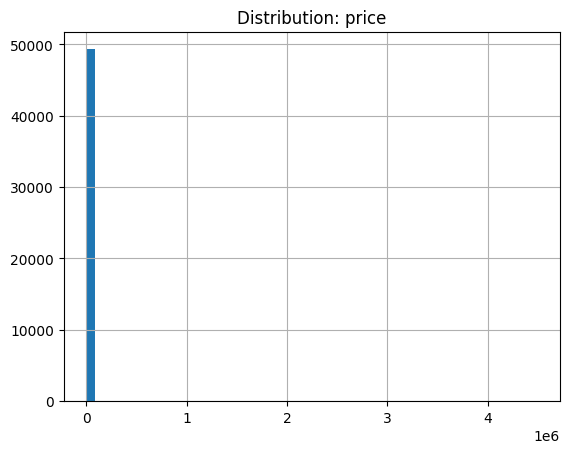

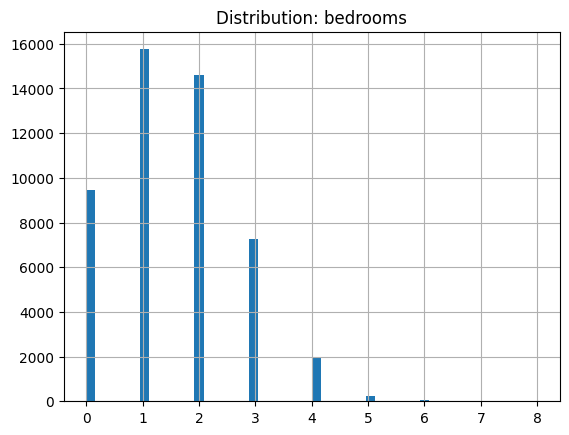

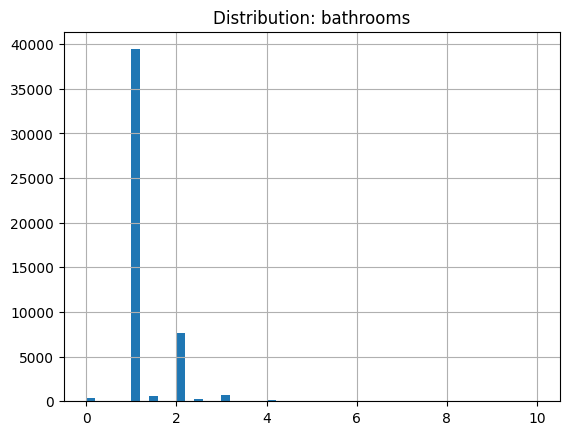

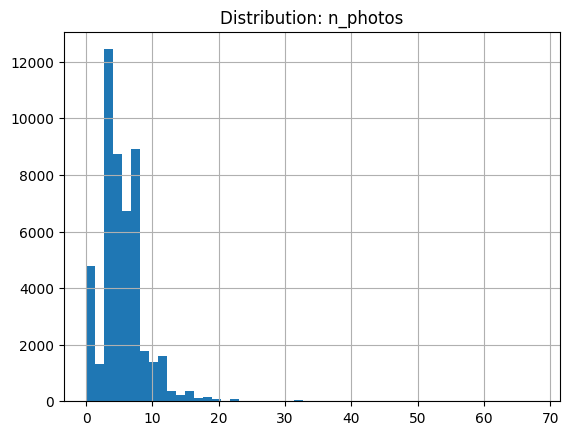

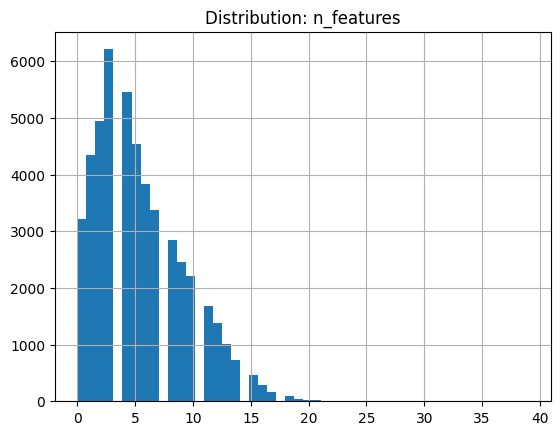

In [8]:
# Numeric distributions (a few key ones)
for col in ["price", "bedrooms", "bathrooms", "n_photos", "n_features"]:
    ax = df[col].hist(bins=50)
    ax.set_title(f"Distribution: {col}")
    plt.show()

## 3) Anomalies (examples)

In [9]:
# Simple anomaly checks
display(df.loc[df["price"] <= 0, ["listing_id","price"]].head())
display(df.loc[df["price"] > df["price"].quantile(0.995), ["listing_id","price","bedrooms","bathrooms"]].head())

# Lat/long sanity (NYC approx ranges)
lat_bad = df[(df["latitude"] < 40.3) | (df["latitude"] > 41.1)]
lon_bad = df[(df["longitude"] < -74.5) | (df["longitude"] > -73.5)]
print("Bad latitude rows:", len(lat_bad))
print("Bad longitude rows:", len(lon_bad))

,listing_id,price


,listing_id,price,bedrooms,bathrooms
514,7232177,58020,3,1.0
1187,7112314,18000,3,3.0
1918,7195303,20000,4,4.0
2471,7108266,24000,4,4.5
2513,7116412,28000,4,4.5


Bad latitude rows: 34
Bad longitude rows: 38


## 4) Missing values

bathrooms               0.0
n_photos                0.0
street_address_clean    0.0
beds_plus_baths         0.0
price_per_bath          0.0
price_per_bed           0.0
created_dow             0.0
created_hour            0.0
created_day             0.0
created_month           0.0
created_year            0.0
created_dt              0.0
features_text           0.0
n_features              0.0
interest_level          0.0
bedrooms                0.0
street_address          0.0
price                   0.0
photos                  0.0
manager_id              0.0
dtype: float64

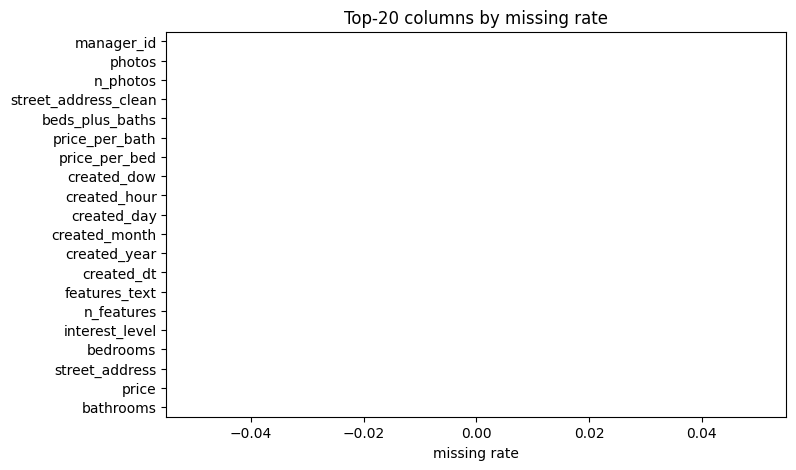

In [10]:
miss = df.isna().mean().sort_values(ascending=False)
display(miss.head(20))

ax = miss.head(20).sort_values().plot(kind="barh", figsize=(8,5))
ax.set_title("Top-20 columns by missing rate")
ax.set_xlabel("missing rate")
plt.show()

## 5) Feature dependencies

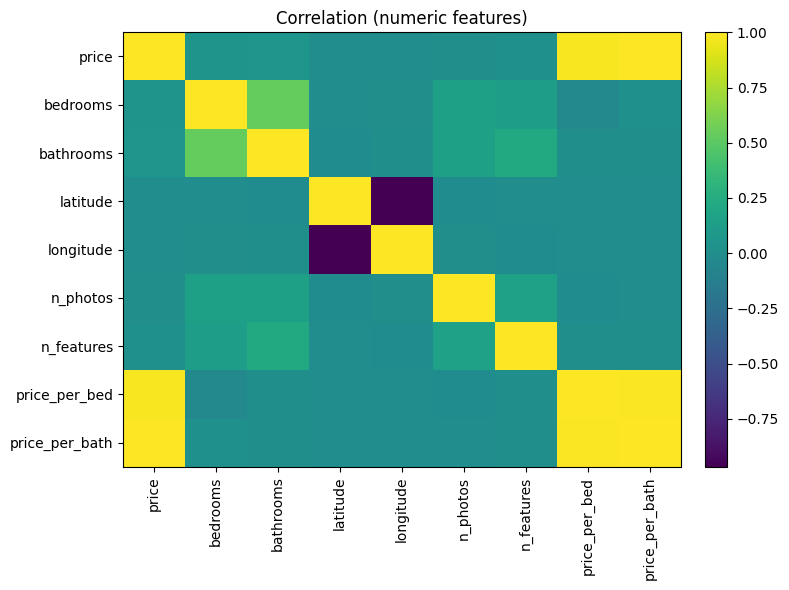

In [11]:
# Correlation heatmap for numeric features (matplotlib only)
corr = df[numeric_cols].corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(corr.values, aspect="auto")
ax.set_xticks(range(len(corr.columns)), corr.columns, rotation=90)
ax.set_yticks(range(len(corr.index)), corr.index)
fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
ax.set_title("Correlation (numeric features)")
plt.tight_layout()
plt.show()

## 6) Hypothesis checks (example mini-research)

Example hypotheses you can keep/refine:

1) **Price efficiency matters**: lower `price_per_bed` → higher probability of `high` interest  
2) **Photos help**: more photos → higher interest  
3) **Text richness matters**: longer descriptions → higher interest (up to saturation)

/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_6097/929797712.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=["low","medium","high"])


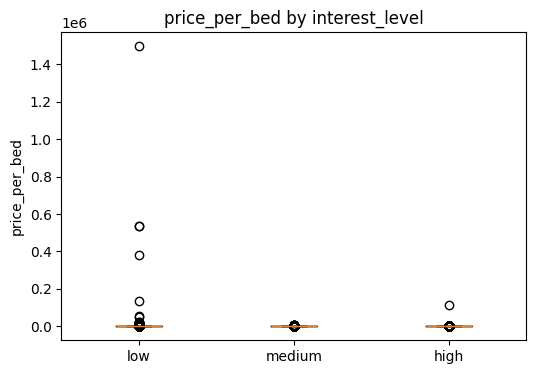

/var/folders/48/64q17bwx0vj129s9_p6bxt400000gn/T/ipykernel_6097/929797712.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(groups, labels=["low","medium","high"])


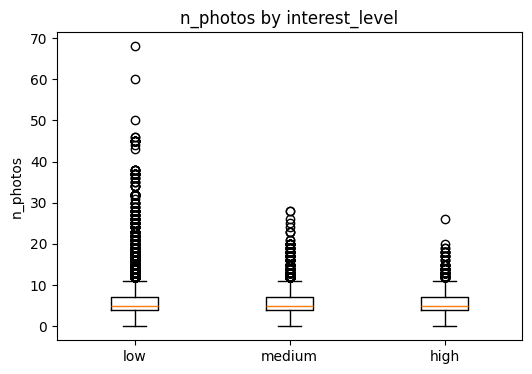

In [12]:
def boxplot_by_target(col: str):
    groups = [df.loc[df[TARGET_COL]==k, col].dropna().values for k in ["low","medium","high"] if k in df[TARGET_COL].unique()]
    fig, ax = plt.subplots(figsize=(6,4))
    ax.boxplot(groups, labels=["low","medium","high"])
    ax.set_title(f"{col} by interest_level")
    ax.set_ylabel(col)
    plt.show()

boxplot_by_target("price_per_bed")
boxplot_by_target("n_photos")